In [1]:
import os
import datetime

import numpy as np
import pandas as pd

import matplotlib as mpl
from matplotlib.collections import PolyCollection
from matplotlib.patches import Polygon
from matplotlib import pyplot as plt

import cartopy
import cartopy.crs as ccrs
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter

# Geographiclib - https://geographiclib.sourceforge.io/Python/2.0/
# conda install conda-forge::geographiclib
from geographiclib.geodesic import Geodesic
geod = Geodesic.WGS84

%matplotlib inline

In [2]:
# plt.rcParams

In [3]:
plt.rcParams['font.size']      = 18
plt.rcParams['font.weight']    = 'bold'
plt.rcParams['axes.titleweight']    = 'bold'
plt.rcParams['axes.grid']      = True
plt.rcParams['axes.xmargin']   = 0
plt.rcParams['grid.linestyle'] = ':'

In [4]:
class EclipseData(object):
    def __init__(self,fname,meta={},track_kwargs={}):
        """
        Load a CSV containing eclipse obscuration data.
        """
        df = pd.read_csv(fname,comment='#')

        height = df['height'].unique()
        n_heights = len(height)
        assert n_heights  == 1, f'One height expected, got: {n_heights}'
        height = height[0]

        # Calculate vectors of center lats and lons.
        center_lats = np.sort(df['lat'].unique())
        center_lons = np.sort(df['lon'].unique())

        # Find the lat/lon step size.
        dlat = center_lats[1] - center_lats[0]
        dlon = center_lons[1] - center_lons[0]

        # Calculate vectors of boundary lats and lons.
        lat_0   = center_lats.min() - dlat/2.
        lat_1   = center_lats.max() + dlat/2.
        lats    = np.arange(lat_0,lat_1+dlat,dlat)

        lon_0 = center_lons.min() - dlon/2.
        lon_1 = center_lons.max() + dlon/2.
        lons    = np.arange(lon_0,lon_1+dlon,dlon)
        
        # These if statements are to handle an error that can occur
        # when dlat or dlon are very small and you get the wrong number
        # of elements due to a small numerical error.
        if len(lats) > len(center_lats)+1:
            lats=lats[:len(center_lats)+1]

        if len(lons) > len(center_lons)+1:
            lons=lons[:len(center_lons)+1]


        cshape      = (len(center_lats),len(center_lons))

        meta['fname']    = fname        
        self.meta        = meta
        self.df          = df
        self.center_lats = center_lats
        self.center_lons = center_lons
        self.cshape      = cshape
        self.lats        = lats
        self.lons        = lons
        self.dlat        = dlat
        self.dlon        = dlon
        self.height      = height
    
        # Load track data.
        self.track_kwargs = track_kwargs
        df_track_csv = fname.replace('MAX_OBSCURATION','ECLIPSE_TRACK')
        if os.path.exists(df_track_csv):
            df_track = pd.read_csv(df_track_csv,parse_dates=[0],comment='#')
            df_track = df_track.set_index('date_ut')
            
            self.df_track = df_track
        else:
            print('File not found: {!s}'.format(df_track_csv))
            print('No eclipse track data loaded.')
            self.df_track = None
        
    def get_obsc_arr(self,obsc_min=0,obsc_max=1):
        """
        Convert the Obscuration DataFrame to a 2D numpy array that can easily be plotted with pcolormesh.

        obsc_min: obscuration values less than this number will be converted to np.nan
        obsc_max: obscuration values greater than this number will be converted to np.nan
        """
        df = self.df.copy()
        
        if obsc_min > 0:
            tf = df['obsc'] < obsc_min
            df.loc[tf,'obsc'] = np.nan
            
        if obsc_max < 1:
            tf = df['obsc'] > obsc_max
            df.loc[tf,'obsc'] = np.nan
            
        obsc_arr    = df['obsc'].to_numpy().reshape(self.cshape)
        
        return obsc_arr
    
    def overlay_obscuration(self,ax,obsc_min=0,alpha=0.65,cmap='gray_r',vmin=0,vmax=1,zorder=1):
        """
        Overlay obscuration values on a map.
        
        ax: axis object to overlay obscuration on.
        """
        obsc_min = self.meta.get('obsc_min',obsc_min)
        alpha    = self.meta.get('alpha',alpha)
        cmap     = self.meta.get('cmap',cmap)
        vmin     = self.meta.get('vmin',vmin)
        vmax     = self.meta.get('vmax',vmax)
        
        lats     = self.lats
        lons     = self.lons
        obsc_arr = self.get_obsc_arr(obsc_min=obsc_min)
        pcoll    = ax.pcolormesh(lons,lats,obsc_arr,vmin=vmin,vmax=vmax,cmap=cmap,zorder=zorder,alpha=alpha)
        
        return {'pcoll':pcoll}
    
    def overlay_track(self,ax,annotate=False,xlim=None,ylim=None,**kw_args):
        """
        Overlay eclipse track on map.
        
        ax: axis object to overlay track values on.
        """
        if self.df_track is None:
            print('No eclipse track data loaded.')
            return
        else:
            df_track = self.df_track
        
        # Annotate places specifed in meta['track_annotate'], but make sure
        # the places are actually on the track.

        # Set default annotation style dictionary.
        tp = {}
        tp['bbox']          = dict(boxstyle='round', facecolor='white', alpha=0.75)
        tp['fontweight']    = 'bold'
        tp['fontsize']      = 12
        tp['zorder']        = 975
        tp['va']            = 'top'

        tas_new = []
        tas = self.meta.get('track_annotate',[]).copy()
        for ta in tas:
            ta_se   = ta.get('startEnd','start')

            tr_lats = df_track['lat'].to_numpy()
            tr_lons = df_track['lon'].to_numpy()

            ta_lat = ta['lat']
            ta_lon = ta['lon']

            ta_lats = np.ones_like(tr_lats)*ta_lat
            ta_lons = np.ones_like(tr_lons)*ta_lon

            ta_rngs = []
            for ta_lat,ta_lon,tr_lat,tr_lon in zip(ta_lats,ta_lons,tr_lats,tr_lons):
                # Determine the ranges and azimuth along the profile path.
                invl    = geod.InverseLine(ta_lat,ta_lon,tr_lat,tr_lon)
                dist    = invl.s13*1e-3   # Distance in km
                # azm     = invl.azi1
                ta_rngs.append(dist)
            
            ta_inx  = np.argmin(ta_rngs)
            
            ta['lat']   = tr_lats[ta_inx]
            ta['lon']   = tr_lons[ta_inx]

            if ta_se == 'start':
                ta['text']  = df_track.index[ta_inx].strftime('%d %b %Y\n%H%M UT')
            else:
                ta['text']  = df_track.index[ta_inx].strftime('%H%M UT')
            
            tp_tmp  = tp.copy()
            ta_tp   = ta.get('tp',{})
            tp_tmp.update(ta_tp)
            ta['tp']    = tp_tmp

            tas_new.append(ta)
        tas = tas_new

        ta_lats = []
        ta_lons = []
        for ta in tas:
            ta_lat  = ta['lat']
            ta_lon  = ta['lon']
            ta_text = ta['text']
            ta_tp   = ta['tp']
            ax.text(ta_lon,ta_lat,'{!s}'.format(ta_text),**ta_tp)

            ta_lats.append(ta_lat)
            ta_lons.append(ta_lon)

        for inx,(rinx,row_0) in enumerate(df_track.iterrows()):
            lat_0 = row_0['lat']
            lon_0 = row_0['lon']

            if len(ta_lats) > 0:
                if lat_0 < np.min(ta_lats) or lat_0 > np.max(ta_lats): continue

            if len(ta_lons) > 0:
                if lon_0 < np.min(ta_lons) or lon_0 > np.max(ta_lons): continue

            if annotate:
                if inx == 0:
                    ax.text(lon_0,lat_0,'{!s}'.format(rinx.strftime('%H%M UT')),**tp)
                if inx == len(df_track)-1:
                    ax.text(lon_0,lat_0,'{!s}'.format(rinx.strftime('%H%M UT')),**tp)

            if inx == len(df_track)-1:
                continue

            row_1 = df_track.iloc[inx+1]
            lat_1 = row_1['lat']
            lon_1 = row_1['lon']

            box = mpl.transforms.TransformedBbox(mpl.transforms.Bbox([[0,0],[1,1]]), ax.transAxes)
            ax.annotate('', xy=(lon_1,lat_1), xytext=(lon_0,lat_0),zorder=950,
                    xycoords='data', size=20,
                    arrowprops=dict(facecolor='red', ec = 'none', arrowstyle="simple",
                connectionstyle="arc3,rad=-0.1"),clip_box=box,clip_on=True)        

        return {}

In [5]:
def plot_map(paths_df=None,plot_eclipse=False,title=None,figsize=(15,8)):
    ## World
    #xlim    = (-180,180)
    #ylim    = (-90,90)
    
    # Continental US (CONUS)
    xlim    = (-130,-56)
    ylim    = (20,55)
    
    ## CONUS + Canada
    #xlim    = (-130,-56)
    #ylim    = (20,80)
    
    fig     = plt.figure(figsize=figsize)
    ax      = fig.add_subplot(111,projection=ccrs.PlateCarree())
    ax.add_feature(cartopy.feature.COASTLINE)
    ax.add_feature(cartopy.feature.BORDERS, linestyle=':')
    ax.set_title('')
    ax.gridlines(draw_labels=True)

    if paths_df is not None:
        fontdict = {'size':'large','weight':'bold'}
        offset   = 1.1
        cycle    = plt.rcParams['axes.prop_cycle']
        for inx,(rinx,row) in enumerate(paths_df.iterrows()):
            color = list(cycle)[inx%len(cycle)].get('color')
            # Plot Transmitter and Receiver locations
            pt_dcts = {}
            pt_dcts['tx'] = {'marker':'*','s':450}
            pt_dcts['rx'] = {'marker':'v','s':150}
            for pt_key,pt_dct in pt_dcts.items():
                lat        = row.get(pt_key+'_lat')
                lon        = row.get(pt_key+'_lon')
                lbl        = row.get(pt_key+'_lbl')

                if lat is None: continue
                    
                latLonStr  = '{:0.1f}\N{DEGREE SIGN}N, {:0.1f}\N{DEGREE SIGN}E'.format(lat,lon)
                if lbl is not None:
                    lbl_latLon = '{!s} ({!s})'.format(lbl,latLonStr)
                else:
                    lbl_latLon = '({!s})'.format(latLonStr)
                if lon > 180:
                    lon = lon - 360.
    
                ax.scatter(lon,lat,zorder=110,label=lbl_latLon,ec='k',fc=color,**pt_dct)
                if lbl is not None:
                    ax.text(lon,lat+offset,lbl,fontdict=fontdict,ha='center',zorder=10000)
            # Plot the path
            if 'end_lat' in row.keys():
                end_key = 'end'
            elif 'rx_lat' in row.keys():
                end_key = 'rx'
            else:
                end_key = None

            if end_key is not None:
                tx_lat       = row.get('tx_lat')
                tx_lon       = row.get('tx_lon')
                
                end_lat      = row.get(end_key+'_lat')
                end_lon      = row.get(end_key+'_lon')
                end_lbl      = row.get(end_key+'_lbl')
                if end_lon > 180:
                    end_lon = end_lon - 360.

                lbl          = '{!s}-{!s}'.format(row['tx_lbl'],end_lbl)
                if end_key == 'end' and 'tx_rx_range_km' in row.keys():
                    rx_rng       = row.get('tx_rx_range_km')
                    end_rng      = row.get('tx_'+end_key+'_range_km')
                    end_azm      = row.get('tx_'+end_key+'_azm')
                    lbl_rngAzm   = '{!s} ({:.0f} km, {:.0f} km, {:.0f}\N{DEGREE SIGN} azm)'.format(lbl,rx_rng,end_rng,end_azm)
                else:
                    end_rng      = row.get('tx_'+end_key+'_range_km')
                    end_azm      = row.get('tx_'+end_key+'_azm')
                    lbl_rngAzm   = '{!s} ({:.0f} km, {:.0f}\N{DEGREE SIGN} azm)'.format(lbl,end_rng,end_azm)


                # Determine the ranges and azimuth along the profile path.
                invl    = geod.InverseLine(tx_lat,tx_lon,end_lat,end_lon)
                dist    = invl.s13*1e-3   # Distance in km
                az      = invl.azi1
                range_step = 1.

                ranges  = np.arange(0,dist,range_step)
        
                glats   = []
                glons   = []
                for x in ranges:
                    s   = min(x*1e3,invl.s13) # invl.s13 is the total line distance in m
                    tmp = invl.Position(s,Geodesic.STANDARD)
                    glat        = tmp['lat2']
                    glon        = tmp['lon2']
        
                    glats.append(glat)
                    glons.append(glon)

                ax.plot(glons,glats,label=lbl_rngAzm,lw=3,color=color,transform=ccrs.PlateCarree())
        if plot_eclipse:
            # ## Load Eclipse Data
            eclipses = {}
    
            meta = {}
            meta['obsc_min']    = 0.85
            meta['alpha']       = 0.25
            meta['cmap']        = mpl.cm.Purples
            fname = 'eclipse_data/20231014.1400_20231014.2100_300kmAlt_0.2dlat_0.2dlon/20231014.1400_20231014.2100_300kmAlt_0.2dlat_0.2dlon_MAX_OBSCURATION.csv.bz2'
    
            tas = []
            ta  = {}
            ta['lat']       = 45.
            ta['lon']       = -128.
            ta['startEnd']  = 'start'
            ta['tp']        = {'va':'bottom'}
            tas.append(ta)
    
            ta  = {}
            ta['lat']       = 22.
            ta['lon']       = -90. 
            ta['startEnd']  = 'end'
            tas.append(ta)
            meta['track_annotate'] = tas
    
            ecl = EclipseData(fname,meta=meta)
            eclipses['2023']    = ecl
    
            meta = {}
            meta['obsc_min']    = 0.975
            fname                   = 'eclipse_data/20240408.1500_20240408.2100_300kmAlt_0.2dlat_0.2dlon/20240408.1500_20240408.2100_300kmAlt_0.2dlat_0.2dlon_MAX_OBSCURATION.csv.bz2'
            tas = []
            ta  = {}
            ta['lat']       = 20
            ta['lon']       = -107.
            ta['startEnd']  = 'start'
            tas.append(ta)
    
            ta  = {}
            ta['lat']       =  47.
            ta['lon']       = -61. 
            ta['startEnd']  = 'end'
            tas.append(ta)
            meta['track_annotate'] = tas
            ecl                     = EclipseData(fname,meta=meta)
            ecl = EclipseData(fname,meta=meta)
            eclipses['2024']    = ecl
    
            for ecl_year,ecl in eclipses.items():
                ecl.overlay_obscuration(ax)
                ecl.overlay_track(ax)
            
    # ax.legend(loc='lower right',fontsize='small')
    ax.legend(loc='lower right',prop={'size':'x-small','weight':'normal'},framealpha=1)
        
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)

    if title is not None:
        ax.set_title(title)
    
    plt.tight_layout()
    plt.show()

In [6]:
class Paths(object):
    def __init__(self,path_dcts):
        """
        Class for processing ray trace path transmitter, receiver, and end point locations.

        path_dcts: List of dictionaries specifying paths. Example:
            pdcts = []
            pdct = {}
            pdct['tx_lat']  =  30.
            pdct['tx_lon']  = -87.
            pdct['tx_lbl']  = 'TX 1'
            pdct['end_lat'] =  50.
            pdct['end_lon'] = -95.
            pdct['end_lbl'] = 'Path 1'
            pdcts.append(pdct)
        """
        self.df = pd.DataFrame(path_dcts)
        self.__add_endPoints__()
        self.__compute_rangeAzms__()
        
    def __compute_rangeAzms__(self):
        """
        Use geographic lib to calcuate the ranges [km] and azimuths [deg clockwise from North]
        of paths dataframe.
        """
        paths_df = self.df
        
        new_rows = []
        for rinx,row in paths_df.iterrows():
            tx_lat = row['tx_lat']
            tx_lon = row['tx_lon']
            endPts = ['rx','end']
            for endPt in endPts:
                end_lat = row.get(endPt+'_lat')
                end_lon = row.get(endPt+'_lon')
                if end_lat is not None:
                    # Determine the ranges and azimuth along the profile path.
                    invl    = geod.InverseLine(tx_lat,tx_lon,end_lat,end_lon)
                    dist    = invl.s13*1e-3   # Distance in km
                    azm     = invl.azi1
    
                    row['tx_{!s}_range_km'.format(endPt)] = dist
                    row['tx_{!s}_azm'.format(endPt)]      = azm
            new_rows.append(row)
    
        new_paths_df = pd.DataFrame(new_rows)
        self.df = new_paths_df

    def __add_endPoints__(self):
        """
        For each row in self.df, if a 'tx_end_range_km' is defined but 'end_lat' is not,
        compute and add an 'end_lat' and 'end_lon' from the tranmitter location
        in the direction of the receiver location for the distance 'tx_end_range_km'.
        """
        paths_df = self.df
        
        new_rows = []
        for rinx,row in paths_df.iterrows():
            if ('tx_end_range_km' in row.keys()) and ('rx_lat' in row.keys()) and ('end_lat' not in row.keys()):
                tx_lat = row['tx_lat']
                tx_lon = row['tx_lon']
                rx_lat = row['rx_lat']
                rx_lon = row['rx_lon']
                
                invl    = geod.InverseLine(tx_lat,tx_lon,rx_lat,rx_lon)
                rx_azm  = invl.azi1
                rng_m  = row['tx_end_range_km']*1e3

                tmp    = geod.Direct(tx_lat, tx_lon, rx_azm, rng_m)
                row['end_lat'] = tmp['lat2']
                row['end_lon'] = tmp['lon2']

                if (row.get('end_lbl') is None) and (row.get('rx_lbl') is not None):
                    row['end_lbl'] = row['rx_lbl']
                    
            new_rows.append(row)
        new_paths_df = pd.DataFrame(new_rows)
        
        self.df = new_paths_df

    def generate_run_list(self,dates_UTC,freqs_MHz,event=''):
        """
        Generate a dataframe with the information needed to run raytraces for 
        each of the paths in self.df.

        dates_UTC: list of datetimes to run the raytrace
        freq_MHz:  list of frequencies in MHz
        event: string with the event name
        """
        new_rows = []
        for date_UTC in dates_UTC:
            for freq_MHz in freqs_MHz:
                for rinx,row in self.df.iterrows():
                    tx_lbl = row.get('tx_lbl')
                    if tx_lbl is None:
                        pass
                    elif tx_lbl.upper() == 'WWV':
                        if freq_MHz not in [2.5, 5, 10, 15, 20, 25]:
                            continue
                    elif tx_lbl.upper() == 'WWVH':
                        if freq_MHz not in [2.5, 5, 10, 15]:
                            continue
                    elif tx_lbl.upper() == 'CHU':
                        if freq_MHz not in [3.33, 7.85, 14.67]:
                            continue
                    
                    row['date_UTC'] = date_UTC
                    row['freq_MHz'] = freq_MHz
                    row['event']    = event

                    new_rows.append(row)
        new_df = pd.DataFrame(new_rows)

        return new_df

# 2023 Annular and 2024 Total Solar Eclipses

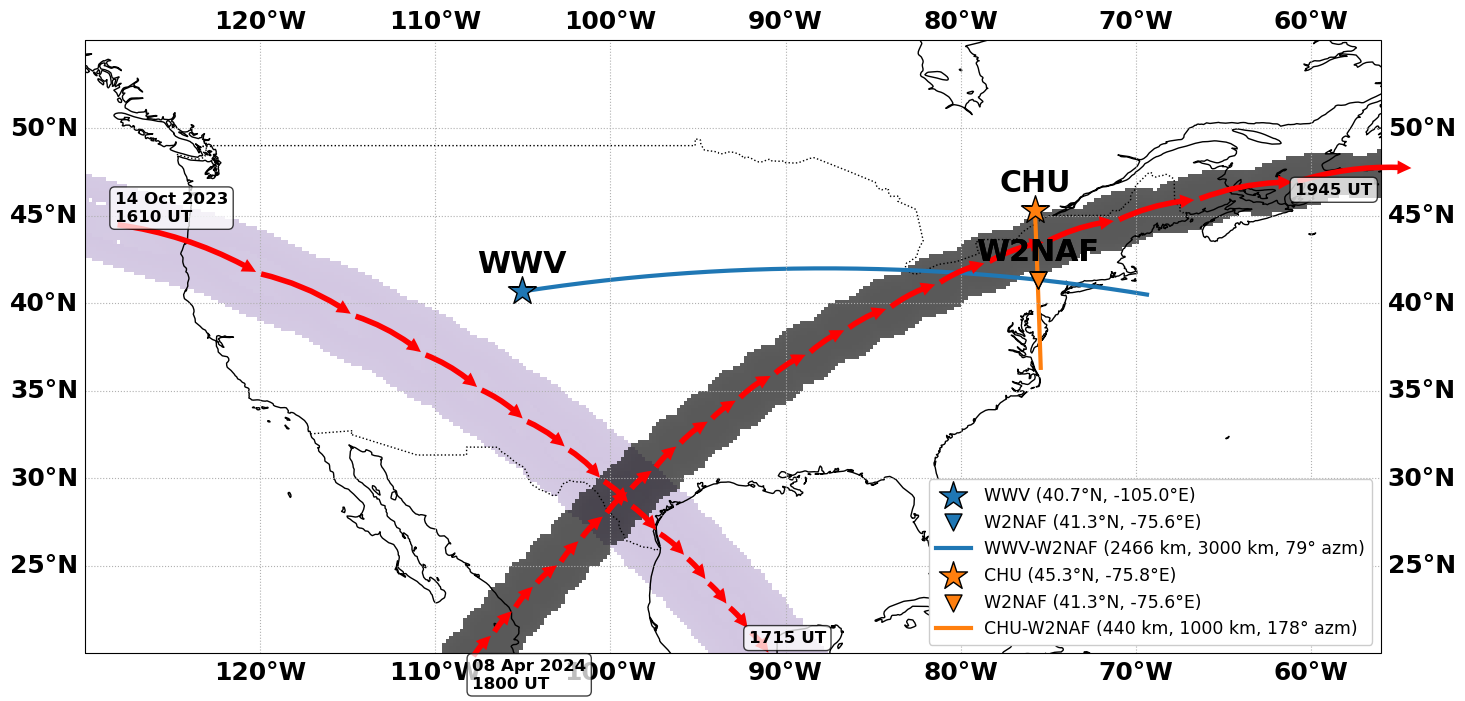

,tx_lbl,tx_lat,tx_lon,rx_lbl,rx_lat,rx_lon,tx_end_range_km,end_lat,end_lon,end_lbl,tx_rx_range_km,tx_rx_azm,tx_end_azm
0,WWV,40.668300,-105.038400,W2NAF,41.335116,-75.600692,3000.0,40.486491,-69.358614,W2NAF,2465.861950,78.545767,78.545767
1,CHU,45.294806,-75.757861,W2NAF,41.335116,-75.600692,1000.0,36.293382,-75.426174,W2NAF,440.101681,178.285607,178.285607


In [7]:
pdcts = []

pdct = {}
pdct['tx_lbl']  = 'WWV'
pdct['tx_lat']  =   40.6683
pdct['tx_lon']  = -105.0384
pdct['rx_lbl']  = 'W2NAF'
pdct['rx_lat']  =  41.335116
pdct['rx_lon']  = -75.600692
pdct['tx_end_range_km'] = 3000.

pdcts.append(pdct)

pdct = {}
pdct['tx_lbl']  = 'CHU'
pdct['tx_lat']  =   45.294806
pdct['tx_lon']  =  -75.757861
pdct['rx_lbl']  = 'W2NAF'
pdct['rx_lat']  =  41.335116
pdct['rx_lon']  = -75.600692
pdct['tx_end_range_km'] = 1000.

pdcts.append(pdct)

title = []
title.append('Annular Solar Eclipe - 14 October 2023')
title.append('Total Solar Eclipe - 8 April 2024')
title = '\n'.join(title)

eclipse_paths = Paths(pdcts)
plot_map(eclipse_paths.df,plot_eclipse=True)
eclipse_paths.df

In [8]:
# Generate a list of ray traces to run for the Solar Eclipses
freqs = []
freqs.append(3.33)
freqs.append(7.85)
freqs.append(14.67)

freqs.append(10)
freqs.append(15)
freqs.append(20)
freqs.append(25)

des = []
des.append((datetime.datetime(2023,10,14,13),    'Annular Solar Eclipse Before'))
des.append((datetime.datetime(2023,10,14,16,45), 'Annular Solar Eclipse During'))

des.append((datetime.datetime(2024,4,8,15), 'Total Solar Eclipse Before'))
des.append((datetime.datetime(2024,4,8,19), 'Total Solar Eclipse During'))

run_lists = []
for date, event in des:
    run_list = eclipse_paths.generate_run_list([date],freqs,event=event)
    run_lists.append(run_list)
eclipse_run_df = pd.concat(run_lists,ignore_index=True)
eclipse_run_df

,tx_lbl,tx_lat,tx_lon,rx_lbl,rx_lat,rx_lon,tx_end_range_km,end_lat,end_lon,end_lbl,tx_rx_range_km,tx_rx_azm,tx_end_azm,date_UTC,freq_MHz,event
0,CHU,45.294806,-75.757861,W2NAF,41.335116,-75.600692,1000.0,36.293382,-75.426174,W2NAF,440.101681,178.285607,178.285607,2023-10-14 13:00:00,3.33,Annular Solar Eclipse Before
1,CHU,45.294806,-75.757861,W2NAF,41.335116,-75.600692,1000.0,36.293382,-75.426174,W2NAF,440.101681,178.285607,178.285607,2023-10-14 13:00:00,7.85,Annular Solar Eclipse Before
2,CHU,45.294806,-75.757861,W2NAF,41.335116,-75.600692,1000.0,36.293382,-75.426174,W2NAF,440.101681,178.285607,178.285607,2023-10-14 13:00:00,14.67,Annular Solar Eclipse Before
3,WWV,40.668300,-105.038400,W2NAF,41.335116,-75.600692,3000.0,40.486491,-69.358614,W2NAF,2465.861950,78.545767,78.545767,2023-10-14 13:00:00,10.00,Annular Solar Eclipse Before
4,WWV,40.668300,-105.038400,W2NAF,41.335116,-75.600692,3000.0,40.486491,-69.358614,W2NAF,2465.861950,78.545767,78.545767,2023-10-14 13:00:00,15.00,Annular Solar Eclipse Before
5,WWV,40.668300,-105.038400,W2NAF,41.335116,-75.600692,3000.0,40.486491,-69.358614,W2NAF,2465.861950,78.545767,78.545767,2023-10-14 13:00:00,20.00,Annular Solar Eclipse Before
6,WWV,40.668300,-105.038400,W2NAF,41.335116,-75.600692,3000.0,40.486491,-69.358614,W2NAF,2465.861950,78.545767,78.545767,2023-10-14 13:00:00,25.00,Annular Solar Eclipse Before
7,CHU,45.294806,-75.757861,W2NAF,41.335116,-75.600692,1000.0,36.293382,-75.426174,W2NAF,440.101681,178.285607,178.285607,2023-10-14 16:45:00,3.33,Annular Solar Eclipse During
8,CHU,45.294806,-75.757861,W2NAF,41.335116,-75.600692,1000.0,36.293382,-75.426174,W2NAF,440.101681,178.285607,178.285607,2023-10-14 16:45:00,7.85,Annular Solar Eclipse During
9,CHU,45.294806,-75.757861,W2NAF,41.335116,-75.600692,1000.0,36.293382,-75.426174,W2NAF,440.101681,178.285607,178.285607,2023-10-14 16:45:00,14.67,Annular Solar Eclipse During


# LSTID Event
## November 3, 2017
1. 1343 UTC
2. 1458 UTC
3. 1613 UTC
4. 1728 UTC

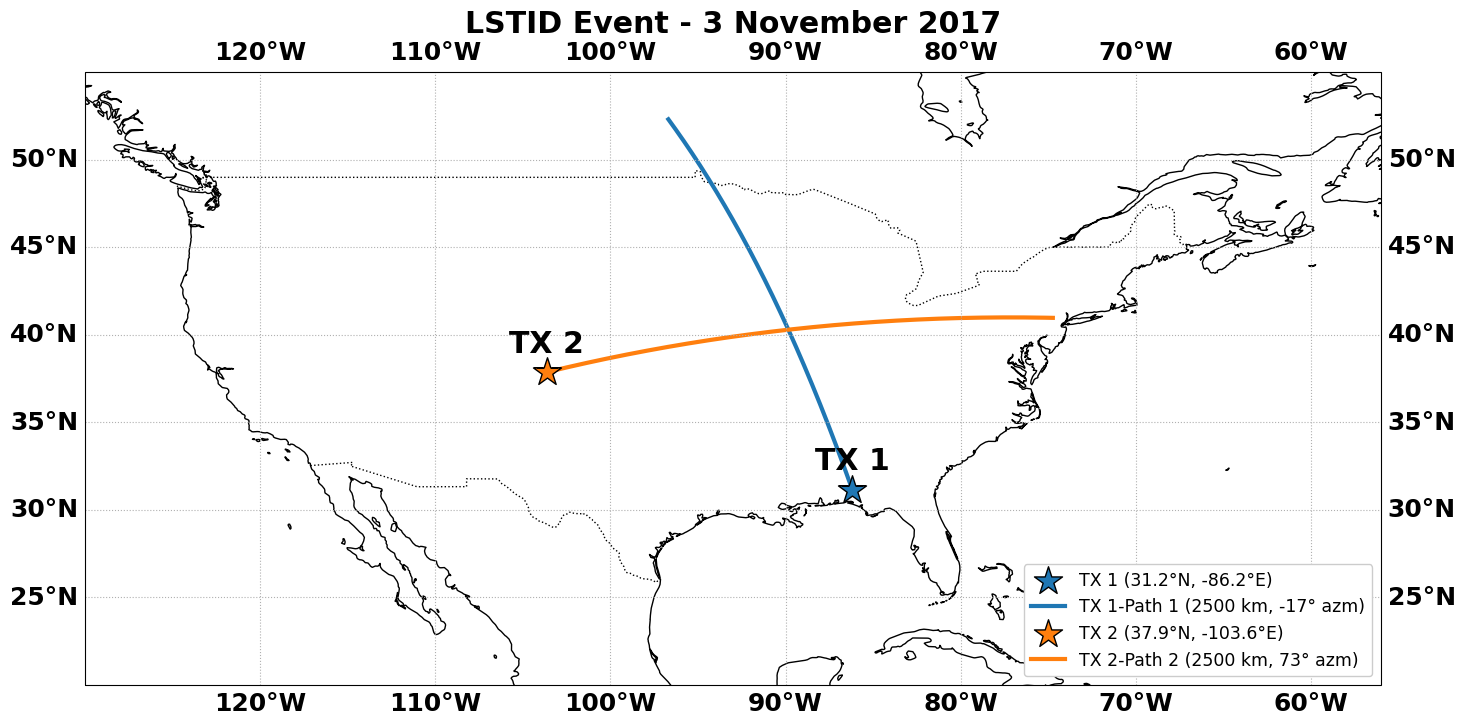

,tx_lat,tx_lon,tx_lbl,end_lat,end_lon,end_lbl,tx_end_range_km,tx_end_azm
0,31.159791,-86.188630,TX 1,52.307369,-96.691351,Path 1,2500.0,-17.0
1,37.870749,-103.627487,TX 2,40.969353,-74.735777,Path 2,2500.0,73.0


In [9]:
ctr_lat =  42.
ctr_lon = -90.
tid_azm = 163.
tx_end_range_rm = 2500.

pdcts = []

pdct = {}
tx_tmp  = geod.Direct(ctr_lat, ctr_lon, tid_azm, (tx_end_range_rm/2.)*1e3)
end_azm = tid_azm + 180.
if end_azm > 360:
    end_azm = end_azm - 360
end_tmp = geod.Direct(tx_tmp['lat2'], tx_tmp['lon2'], end_azm, tx_end_range_rm*1e3)
pdct['tx_lat']  = tx_tmp['lat2']
pdct['tx_lon']  = tx_tmp['lon2']
pdct['tx_lbl']  = 'TX 1'
pdct['end_lat'] = end_tmp['lat2']
pdct['end_lon'] = end_tmp['lon2']
pdct['end_lbl'] = 'Path 1'
pdcts.append(pdct)

pdct = {}
tid_azm = tid_azm +90.
tx_tmp  = geod.Direct(ctr_lat, ctr_lon, tid_azm, (tx_end_range_rm/2.)*1e3)
end_azm = tid_azm + 180.
if end_azm > 360:
    end_azm = end_azm - 360
end_tmp = geod.Direct(tx_tmp['lat2'], tx_tmp['lon2'], end_azm, tx_end_range_rm*1e3)
pdct['tx_lat']  = tx_tmp['lat2']
pdct['tx_lon']  = tx_tmp['lon2']
pdct['tx_lbl']  = 'TX 2'
pdct['end_lat'] = end_tmp['lat2']
pdct['end_lon'] = end_tmp['lon2']
pdct['end_lbl'] = 'Path 2'
pdcts.append(pdct)

lstid_paths = Paths(pdcts)

title = []
title.append('LSTID Event')
title.append('3 November 2017')
title = ' - '.join(title)

plot_map(lstid_paths.df,title=title)
lstid_paths.df

In [10]:
# Generate a List of Raytraces to run for the LSTID Event
dates = []
dates.append(datetime.datetime(2017,11,3,13,43))
dates.append(datetime.datetime(2017,11,3,14,58))
dates.append(datetime.datetime(2017,11,3,16,13))
dates.append(datetime.datetime(2017,11,3,17,28))

freqs = []
freqs.append(14)

event = 'LSTID Event'

lstid_run_df = lstid_paths.generate_run_list(dates,freqs,event=event)
lstid_run_df

,tx_lat,tx_lon,tx_lbl,end_lat,end_lon,end_lbl,tx_end_range_km,tx_end_azm,date_UTC,freq_MHz,event
0,31.159791,-86.188630,TX 1,52.307369,-96.691351,Path 1,2500.0,-17.0,2017-11-03 13:43:00,14,LSTID Event
1,37.870749,-103.627487,TX 2,40.969353,-74.735777,Path 2,2500.0,73.0,2017-11-03 13:43:00,14,LSTID Event
0,31.159791,-86.188630,TX 1,52.307369,-96.691351,Path 1,2500.0,-17.0,2017-11-03 14:58:00,14,LSTID Event
1,37.870749,-103.627487,TX 2,40.969353,-74.735777,Path 2,2500.0,73.0,2017-11-03 14:58:00,14,LSTID Event
0,31.159791,-86.188630,TX 1,52.307369,-96.691351,Path 1,2500.0,-17.0,2017-11-03 16:13:00,14,LSTID Event
1,37.870749,-103.627487,TX 2,40.969353,-74.735777,Path 2,2500.0,73.0,2017-11-03 16:13:00,14,LSTID Event
0,31.159791,-86.188630,TX 1,52.307369,-96.691351,Path 1,2500.0,-17.0,2017-11-03 17:28:00,14,LSTID Event
1,37.870749,-103.627487,TX 2,40.969353,-74.735777,Path 2,2500.0,73.0,2017-11-03 17:28:00,14,LSTID Event


# List of Raytraces to Run

In [11]:
run_df = pd.concat([eclipse_run_df,lstid_run_df],ignore_index=True)
run_df.to_csv('run_raytraces.csv',index=False)
run_df

,tx_lbl,tx_lat,tx_lon,rx_lbl,rx_lat,rx_lon,tx_end_range_km,end_lat,end_lon,end_lbl,tx_rx_range_km,tx_rx_azm,tx_end_azm,date_UTC,freq_MHz,event
0,CHU,45.294806,-75.757861,W2NAF,41.335116,-75.600692,1000.0,36.293382,-75.426174,W2NAF,440.101681,178.285607,178.285607,2023-10-14 13:00:00,3.33,Annular Solar Eclipse Before
1,CHU,45.294806,-75.757861,W2NAF,41.335116,-75.600692,1000.0,36.293382,-75.426174,W2NAF,440.101681,178.285607,178.285607,2023-10-14 13:00:00,7.85,Annular Solar Eclipse Before
2,CHU,45.294806,-75.757861,W2NAF,41.335116,-75.600692,1000.0,36.293382,-75.426174,W2NAF,440.101681,178.285607,178.285607,2023-10-14 13:00:00,14.67,Annular Solar Eclipse Before
3,WWV,40.668300,-105.038400,W2NAF,41.335116,-75.600692,3000.0,40.486491,-69.358614,W2NAF,2465.861950,78.545767,78.545767,2023-10-14 13:00:00,10.00,Annular Solar Eclipse Before
4,WWV,40.668300,-105.038400,W2NAF,41.335116,-75.600692,3000.0,40.486491,-69.358614,W2NAF,2465.861950,78.545767,78.545767,2023-10-14 13:00:00,15.00,Annular Solar Eclipse Before
5,WWV,40.668300,-105.038400,W2NAF,41.335116,-75.600692,3000.0,40.486491,-69.358614,W2NAF,2465.861950,78.545767,78.545767,2023-10-14 13:00:00,20.00,Annular Solar Eclipse Before
6,WWV,40.668300,-105.038400,W2NAF,41.335116,-75.600692,3000.0,40.486491,-69.358614,W2NAF,2465.861950,78.545767,78.545767,2023-10-14 13:00:00,25.00,Annular Solar Eclipse Before
7,CHU,45.294806,-75.757861,W2NAF,41.335116,-75.600692,1000.0,36.293382,-75.426174,W2NAF,440.101681,178.285607,178.285607,2023-10-14 16:45:00,3.33,Annular Solar Eclipse During
8,CHU,45.294806,-75.757861,W2NAF,41.335116,-75.600692,1000.0,36.293382,-75.426174,W2NAF,440.101681,178.285607,178.285607,2023-10-14 16:45:00,7.85,Annular Solar Eclipse During
9,CHU,45.294806,-75.757861,W2NAF,41.335116,-75.600692,1000.0,36.293382,-75.426174,W2NAF,440.101681,178.285607,178.285607,2023-10-14 16:45:00,14.67,Annular Solar Eclipse During
